<a href="https://colab.research.google.com/github/sanjana-mishra/crochet-companion/blob/main/Detectron2_Crochet_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train custom instance segmentation model using Detectron2

**Installation of Detectron2**

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 15528 (delta 82), reused 185 (delta 41), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (11193/11193), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # threshold
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


[04/12 03:45:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Running inference on a crochet sample.

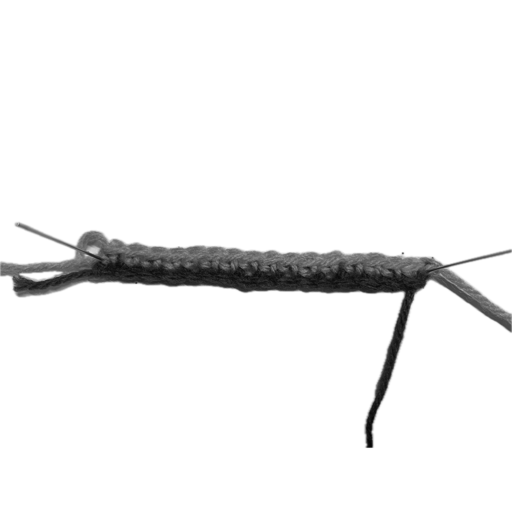

In [8]:
cr_im = cv2.imread("/content/data/train/train_1.png")
cv2_imshow(cr_im)

Some predictions. Bound to get incorrcect reuslts as the model mask_rcnn_R_50_FPN_3x has no idea about my sample and was not trained on crochet stitches.

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


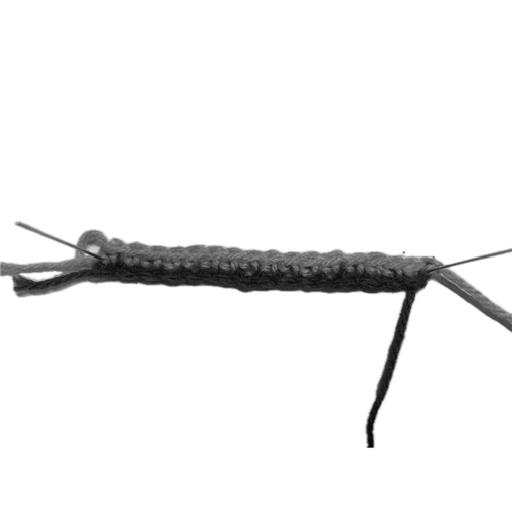

In [9]:
sci_outputs = predictor(cr_im)
sci_v = Visualizer(cr_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
cr_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(cr_out.get_image()[:, :, ::-1])

As expected, as there are no crochet items in COCO, the model performs poorly. Here there is an umbrella, can get absolutely nothing recognized as well.

# Train on a crochet stitch dataset

Importing the necessary function to register datasets in the COCO format. Registering both the training and validation datasets. Working with training (and validation) data that is is the coco format where there is a single JSON file that describes all the annotations from all training images. <p>
Naming convention: training data is 'my_dataset_train' and the validation data is 'my_dataset_val'.



In [13]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, "/content/data/train/anno_train.json", "/content/data/train")
register_coco_instances("dataset_val", {}, "/content/data/val/anno_val.json", "/content/data/val")

Extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc.

In [14]:
train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

[04/12 03:47:36 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/data/train/anno_train.json


In [15]:
val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")


[04/12 03:47:38 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/data/val/anno_val.json


In [16]:
from matplotlib import pyplot as plt

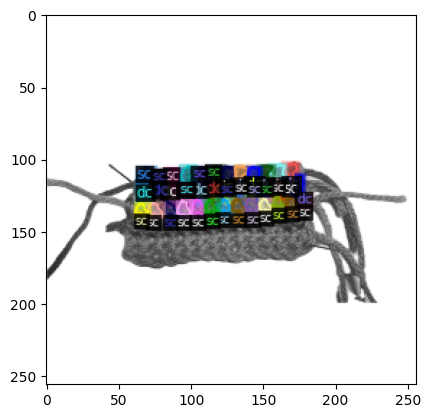

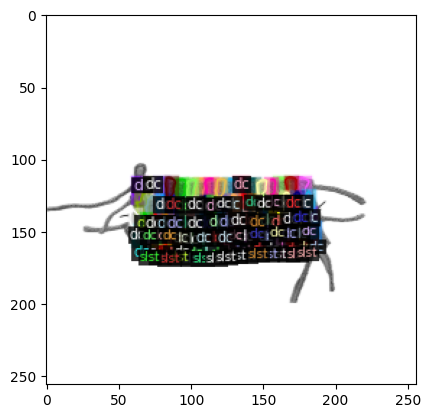

In [17]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [18]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/models/detectron2_models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # batch size
cfg.SOLVER.BASE_LR = 0.0003  # learning rate
cfg.SOLVER.MAX_ITER = 2000    # iterations
cfg.SOLVER.STEPS = []        # not decaying learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 4 classes (exclusing background)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) # Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) # Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/12 03:48:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [19]:
trainer.train() #Start the training process

[04/12 03:48:09 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/12 03:48:19 d2.utils.events]:  eta: 0:12:00  iter: 19  total_loss: 7.847  loss_cls: 1.619  loss_box_reg: 0.07913  loss_mask: 0.6937  loss_rpn_cls: 5.13  loss_rpn_loc: 0.3397    time: 0.3708  last_time: 0.3790  data_time: 0.0140  last_data_time: 0.0052   lr: 5.9943e-06  max_mem: 1975M
[04/12 03:48:30 d2.utils.events]:  eta: 0:12:17  iter: 39  total_loss: 5.81  loss_cls: 1.455  loss_box_reg: 0.4331  loss_mask: 0.6926  loss_rpn_cls: 2.698  loss_rpn_loc: 0.2658    time: 0.3873  last_time: 0.3845  data_time: 0.0086  last_data_time: 0.0125   lr: 1.1988e-05  max_mem: 2276M
[04/12 03:48:38 d2.utils.events]:  eta: 0:12:29  iter: 59  total_loss: 3.164  loss_cls: 1.263  loss_box_reg: 0.4361  loss_mask: 0.6912  loss_rpn_cls: 0.39  loss_rpn_loc: 0.2414    time: 0.3983  last_time: 0.3857  data_time: 0.0094  last_data_time: 0.0055   lr: 1.7982e-05  max_mem: 2276M
[04/12 03:48:47 d2.utils.events]:  eta: 0:12:45  iter: 79  total_loss: 2.699  loss_cls: 0.9978  loss_box_reg: 0.5361  loss_mask: 0.6896

Save the config file.

In [20]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/models/detectron2_models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [21]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/12 04:24:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/models/detectron2_models/model_final.pth ...


Verify segmentation on random validation images

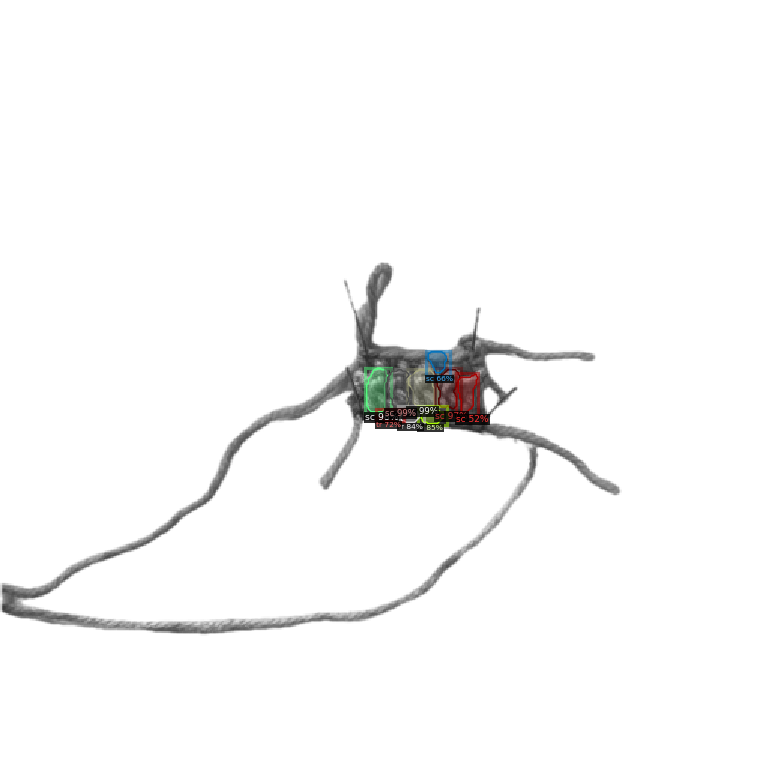

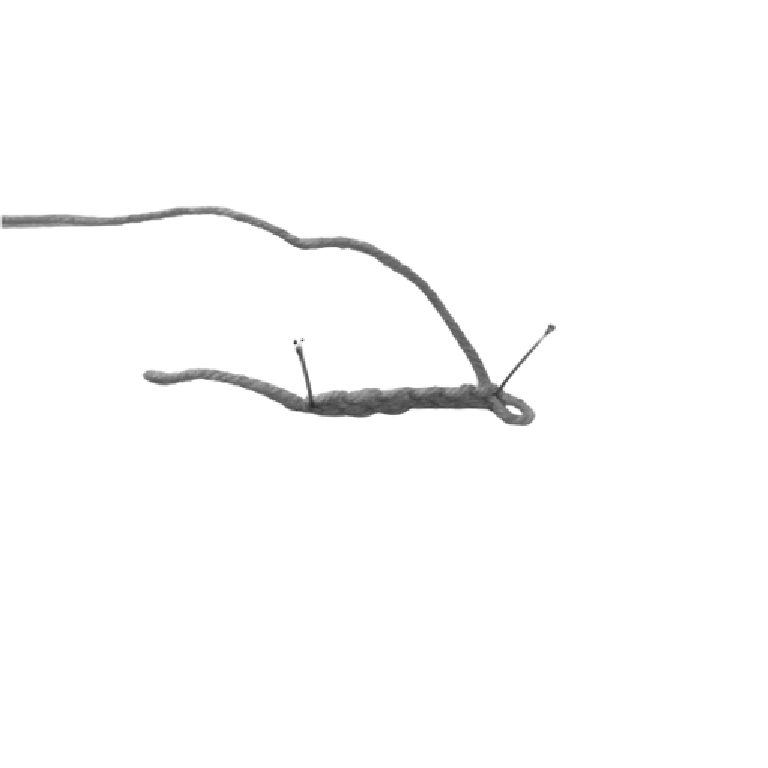

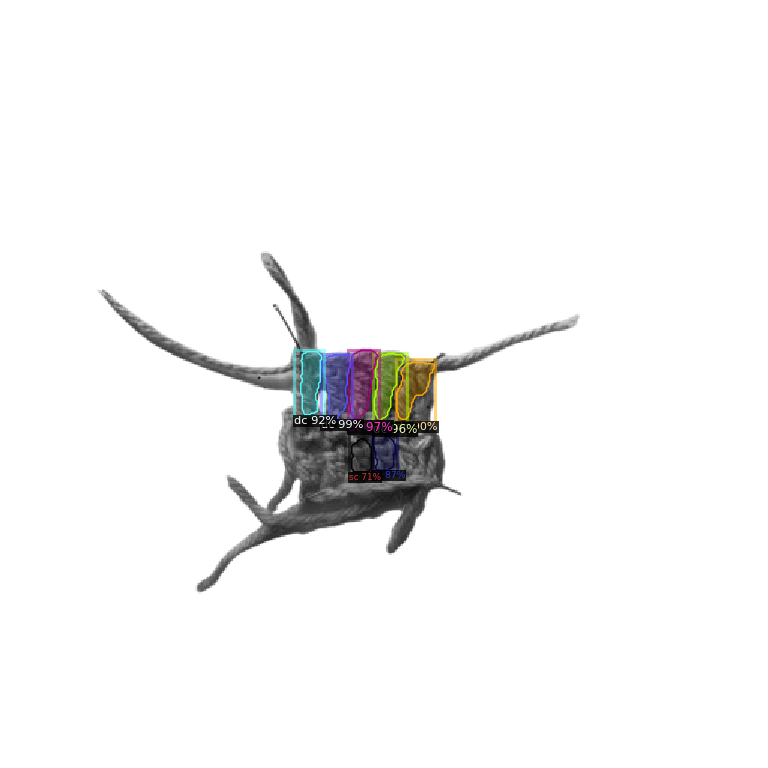

In [22]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 3):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Average precision and recall.

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[04/12 04:25:22 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[04/12 04:25:22 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/data/val/anno_val.json
[04/12 04:25:22 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    slst    | 22           |     sc     | 15           |     dc     | 15           |
|     tr     | 11           |            |              |            |              |
|   total    | 63           |            |              |            |              |
[04/12 04:25:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/12 04:25:22 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[04/12 04:25:23 d2.evaluation.evaluator]: Total inference time: 0:00:00.133486 (0.133486 s / iter per device, on 1 devices)
[04/12 04:25:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.079507 s / iter per device, on 1 devices)
[04/12 04:25:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/12 04:25:23 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[04/12 04:25:23 d2.evaluation.coco_evaluation]: Evaluating predictions with official COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.010
 Average

**Load a new image and segment it.**

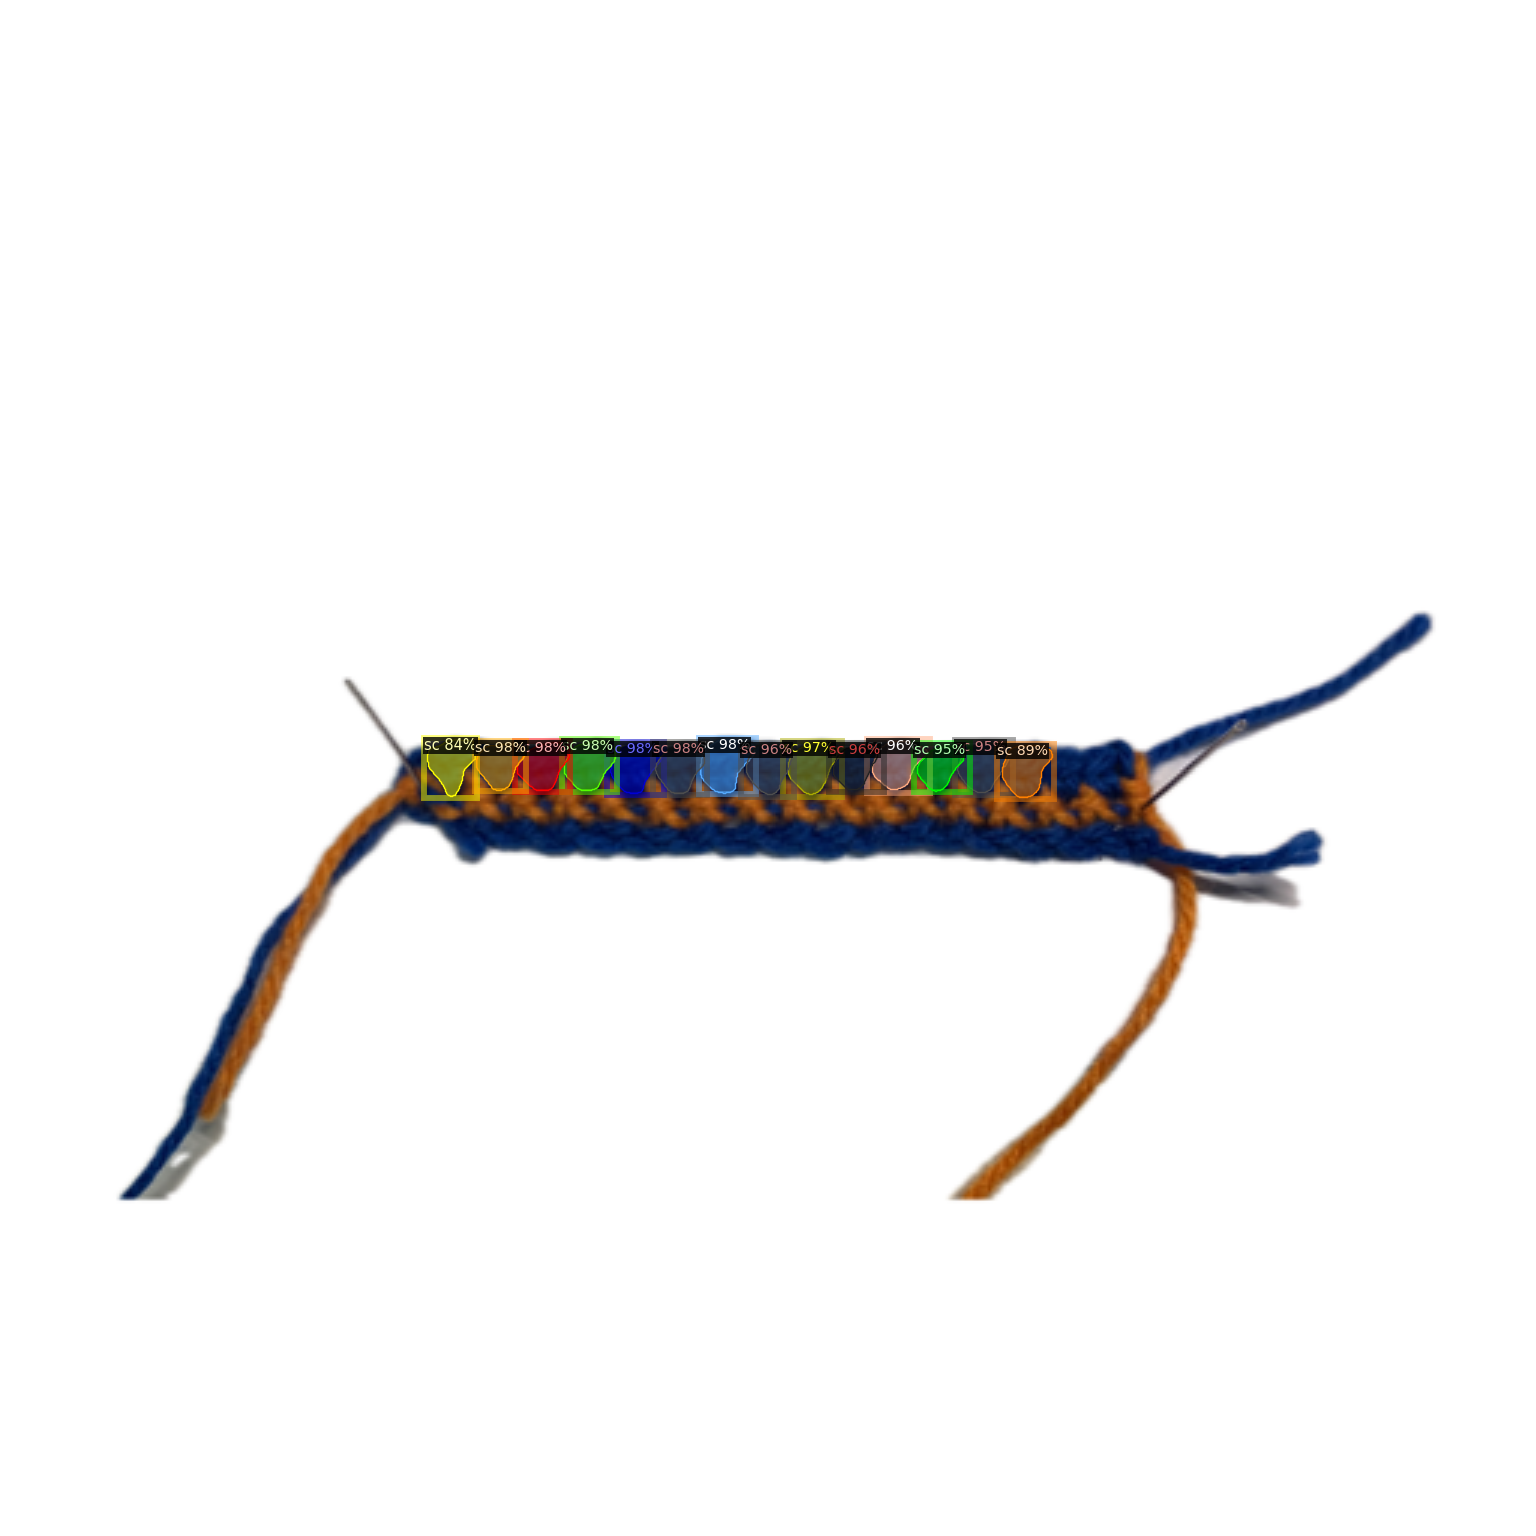

In [28]:
new_im = cv2.imread("/content/data/test/test_50.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# cv2_imshow(out.get_image()[:, :, ::-1])

scale_factor = 3  # You can adjust this as needed
resized_im = cv2.resize(new_im, None, fx=scale_factor, fy=scale_factor)

# Run prediction on the resized image
outputs = predictor(resized_im)

# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(resized_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the result
cv2_imshow(out.get_image()[:, :, ::-1])

